# **Engineering a Kerr-based Deterministic Cubic Phase Gate via Gaussian Operations in Strawberry Fields**

In [4]:
import strawberryfields as sf
from strawberryfields.ops import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### **Define Useful Functions**

In [ ]:
""" Plotting """

def plot_wigner(state, title = "Wigner Function of State", range = 20):
    fig = plt.figure()
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    fig.tight_layout()
    
    plt.show()
    
def ax_plot_wigner(ax, state, title, range=20):
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax.plot_surface(X, P, Z, cmap='RdYlGn', lw=0.5, rstride=1, cstride=1)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    
# plot  Wigner function on 2D surface
def plot_wigner_2d(state, title = "Wigner Function of State", range = 20):
    fig = plt.figure()
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    ax = fig.add_subplot(111)
    contour = ax.contourf(X, P, Z, cmap='RdYlGn')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    # add colorbar
    cbar = plt.colorbar(contour)
    cbar.set_label('Wigner Function')
    
    fig.tight_layout()
    
    plt.show()
    
def ax_plot_wigner_2d(ax, state, title, range = 20):
    x = np.linspace(-range, range, 100)
    p = np.linspace(-range, range, 100)
    Z = state.wigner(0, x, p)
    X, P = np.meshgrid(x, p)
    contour = ax.contourf(X, P, Z, cmap='RdYlGn')
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('P')
    # add colorbar
    cbar = plt.colorbar(contour)
    cbar.set_label('Wigner Function')
    # set axis to have equal aspect ratio
    ax.set_aspect('equal')
    
def plot_kets(simstate, target_state):
    simket = simstate.ket()
    targetket = target_state.ket()

    # plot the real and imaginary parts of the state
    fig = plt.figure(figsize = (12, 5))
    fig.suptitle("Comparison of Simulated and Target States")
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.plot(np.real(simket), label = "Simulated")
    ax1.plot(np.real(targetket), label = "Target")
    ax1.set_title("Real Part")
    ax2.plot(np.imag(simket), label = "Simulated")
    ax2.plot(np.imag(targetket), label = "Target")
    ax2.set_title("Imaginary Part")
    plt.legend()
    plt.grid()
    plt.show()
    
def plot_probs_fock(state):
    p_n = state.all_fock_probs()  
    # plot s.t. each point is a number - the n value of the Fock state i.e. for the 0-th fock state the plot has text point '0' at p_n[0]
    plt.figure(figsize=(10, 5) )
    plt.bar(range(len(p_n)), p_n)
    plt.xlabel('Fock State')
    plt.ylabel('Probability')
    plt.title('Fock State Probabilities')
    plt.show()

""" Other """
def get_fidelity_error(state1, state2, backend = "fock"):
    return 1 - state1.fidelity(other_state = state2.ket(), mode = 0).numpy().item() if backend == "tf" else 1 - state1.fidelity(other_state = state2.ket(), mode = 0)

def get_ket_error(state1, state2):
    return np.linalg.norm(state1.ket() - state2.ket()) # returns L2 norm of difference

def get_wigner_error(state1, state2):
    x = np.linspace(-20, 20, 100)
    p = np.linspace(-20, 20, 100)
    Z1 = state1.wigner(0, x, p)
    Z2 = state2.wigner(0, x, p)
    return np.linalg.norm(Z1 - Z2) # returns L2 norm of wigner difference

### **Define Simulation**

Within the simulation we implement driven Kerr Hamiltonian
$$
\hat{H}_{\text{Kerr}} = -\frac{\chi}{2} \hat{a}^\dagger{}^2 \hat{a}^2 + \delta \hat{a}^\dagger \hat{a} + \beta (\hat{a} + \hat{a}^\dagger)
$$
and approximate its propagator for a small timestep $dt$ as
$$
\hat{U}_{dt} = e^{-i[-\frac{\chi}{2} \hat{a}^\dagger{}^2 \hat{a}^2 + \delta \hat{a}^\dagger \hat{a} + \beta (\hat{a} + \hat{a}^\dagger)]dt} \approx e^{i\frac{\chi}{2} (\hat{n}^2 - \hat{a}^\dagger \hat{a})dt} e^{-i\delta \hat{a}^\dagger \hat{a}dt} e^{-i\beta (\hat{a} + \hat{a}^\dagger)dt} = K(\frac{\chi}{2}dt)R(-\frac{\chi}{2}dt)R(-\delta dt)D(\beta dt e^{i\frac{3 \pi}{2}})
$$

with
$$
K(\kappa) = \exp\left( i \kappa \hat{n}^2 \right)
$$

$$
R(\phi) = \exp\left( i \phi \hat{a}^\dagger \hat{a} \right)
$$

$$
D(\alpha) = \exp\left( \alpha \hat{a}^\dagger - \alpha^* \hat{a} \right) = \exp\left( r \left( e^{i\phi} \hat{a}^\dagger - e^{-i\phi} \hat{a} \right) \right)
$$










In [6]:
def simulate_cubic_phase_gate(
    N,
    cutoff_dim,
    backend,
    start_state,
    gamma,
    lamdB,
    alpha,
    chi,
    sqphi=0,
    phi=0,
    ndphi=3 * np.pi / 2
):
    """
    Simulate a cubic phase gate via a sequence of squeezing, displacement, 
    and nonlinear steps, and compare it to the ideal cubic phase gate.

    Parameters:
        N (int): Number of discretization steps.
        cutoff_dim (int): Fock basis truncation dimension.
        backend (str): Backend to use (e.g. "fock").
        start_state: The initial state (e.g. sf.ops.GKP([0,0]), sf.ops.Catstate(), etc.).
        gamma (float): Target gate angle for the cubic phase gate.
        lamdB (float): Squeezing level in dB.
        alpha (float): Displacement amplitude along x.
        chi (float): Nonlinearity strength.
        sqphi (float, optional): Squeezing phase. Default is 0.
        phi (float, optional): Displacement phase. Default is 0.
        ndphi (float, optional): Displacement phase for the nonlinear step. Default is 3π/2.

    Returns:
        tuple: (simstate, target_state)
            simstate: State after applying the approximated cubic phase gate.
            target_state: State after applying the ideal cubic phase gate.
    """
    # Calculate squeezing parameters
    lam = np.sqrt(10 ** (lamdB / 10))
    rsq = -np.log(lam)
    
    # Displacement amplitude in r-form
    rd = np.abs(alpha)
    
    # Calculate detuning and drive for the nonlinear step
    detuning = 3 * chi * alpha**2 - chi
    drive = -2 * chi * alpha**3
    
    # Gate time and time step
    t = np.sqrt(2) * gamma / (chi * alpha * lam**3)
    dt = t / N
    
    # Parameters for the cubic phase gate step
    nkappa = chi / 2.0 * dt
    nrphi = -detuning * dt
    nr = drive * dt
    
    # Build the simulation program (approximate cubic phase gate)
    prog = sf.Program(1)
    with prog.context as q:
        start_state | q[0]
        # Direct operations: squeezing then displacement
        Sgate(rsq, sqphi) | q[0]
        Dgate(rd, phi) | q[0]
        
        # Nonlinear step(s)
        for i in range(N):
            Rgate(-chi / 2 * dt) | q[0]
            Kgate(nkappa) | q[0]
            Rgate(nrphi) | q[0]
            Dgate(nr, ndphi) | q[0]
        
        # Inverse operations: displacement then squeezing
        Dgate(-rd, phi) | q[0]
        Sgate(-rsq, sqphi) | q[0]
    
    eng = sf.Engine(backend, backend_options={"cutoff_dim": cutoff_dim})
    simstate = eng.run(prog).state
    
    # Build the target program (ideal cubic phase gate)
    prog_target = sf.Program(1)
    with prog_target.context as q:
        start_state | q[0]
        Vgate(gamma) | q[0]
    
    eng_target = sf.Engine(backend, backend_options={"cutoff_dim": cutoff_dim})
    target_state = eng_target.run(prog_target).state
    
    return simstate, target_state

#### **Use Vacuum State**

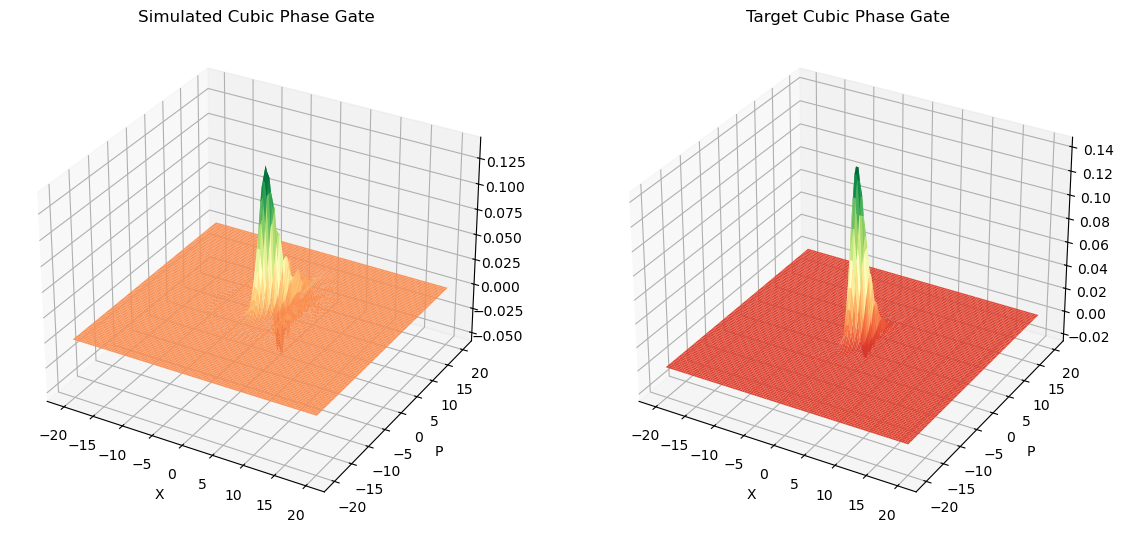

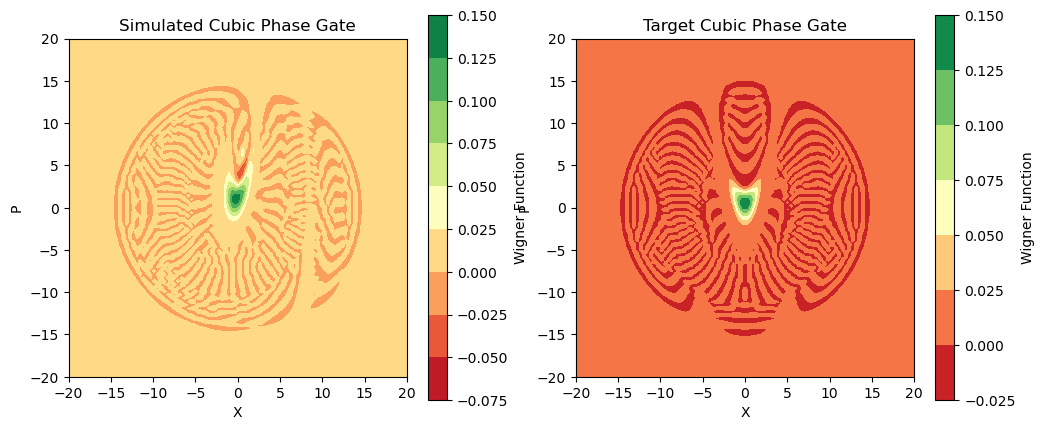

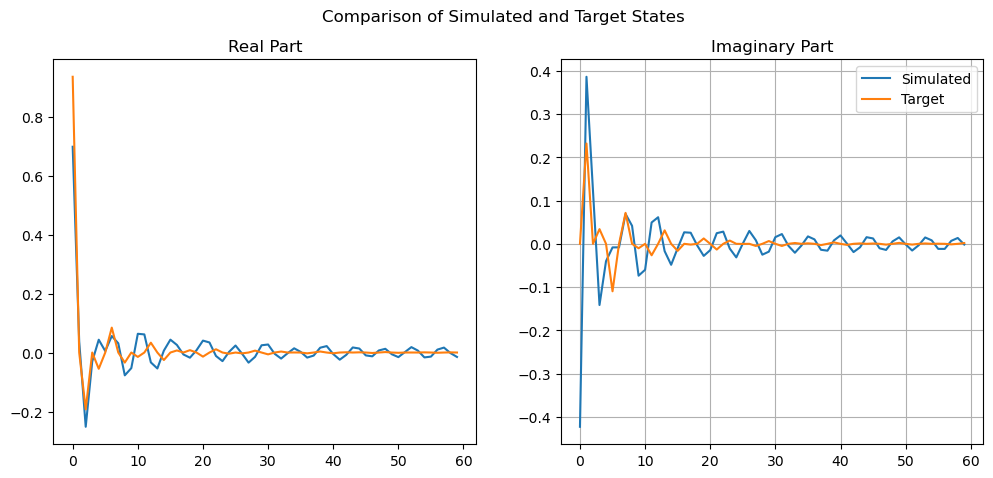

Fidelity Error =  0.19668593611898577
Ket Error =  0.6420127155901639


In [9]:
# set constant parameters
N = 10
cutoff_dim = 60 # Fock basis truncation
backend = "fock" # backend to use
gamma = 0.7 # target gate angle
start_state = Vac #sf.ops.GKP([0, 0]) for gkp state
lamdB = 5 # squeezing level in dB
alpha = 3.5 # displacement amplitude - how much we displace the state along x
chi = 0.5 # scales t 

# Run simulation
simstate, target_state = simulate_cubic_phase_gate(
    N, cutoff_dim, backend, start_state, gamma, lamdB, alpha, chi
)

# plot the Wigner function of the simulated and target states
fig = plt.figure(figsize = (14, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax_plot_wigner(ax1, simstate, "Simulated Cubic Phase Gate")
ax_plot_wigner(ax2, target_state, "Target Cubic Phase Gate")
plt.show()

# plot 2d Wigner function
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax_plot_wigner_2d(ax1, simstate, "Simulated Cubic Phase Gate")
ax_plot_wigner_2d(ax2, target_state, "Target Cubic Phase Gate")
plt.show()

# plot kets
plot_kets(simstate, target_state)

print("Fidelity Error = ", get_fidelity_error(simstate, target_state, backend))
print("Ket Error = ", get_ket_error(simstate, target_state))